<a href="https://colab.research.google.com/github/Lois-Lanctot/student-performance-analysis/blob/main/student_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [914]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import pointbiserialr, f_oneway

!pip3 install ppscore
import ppscore as pps


In [915]:
# changes catagorical columns into numerical columns using One-Hot Encoding
def create_preprocessor(features):
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), features)
        ],
        remainder='passthrough'
    )


# trains a ML model using a pipline and evaluates it's performance
def train_and_evaluate_model(model, model_name, features):
    preprocessor = create_preprocessor(features)

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Evaluate the model performance using MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_scores[model_name] = mae
    rmse_scores[model_name] = rmse


# exams.csv

3 highschools in the US

In [916]:
# read exams.csv into a DataFrame
exams_df = pd.read_csv("/content/exams.csv")
exams_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [917]:
# print exams.csv info
exams_df.info()
print("Columns: ", exams_df.columns)
print("Record Count: ", len(exams_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
Columns:  Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
Record Count:  1000


In [918]:
# check if there are any null values
print(exams_df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [919]:
# print unique values for the catagorical columns
print(exams_df['gender'].unique())
print(exams_df['race/ethnicity'].unique())
print(exams_df['parental level of education'].unique())
print(exams_df['lunch'].unique())
print(exams_df['test preparation course'].unique())

['female' 'male']
['group D' 'group B' 'group C' 'group E' 'group A']
['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']
['standard' 'free/reduced']
['completed' 'none']


In [920]:
# visulaize the distribution of the catagorical columns
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# for col in categorical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.countplot(exams_df[col])
#     plt.title(f'Distribution of {col}')
#     plt.show()


In [921]:
# visulaize the distribution of the numerical columns
numerical_cols = ['math score', 'reading score', 'writing score']
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(exams_df[col], kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.show()

#     sns.boxplot(x=exams_df[col])
#     plt.title(f'Box plot of {col}')
#     plt.show()


In [922]:
# remove outliers
columns_to_check = [
    'gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'
]
z_scores = stats.zscore(exams_df[columns_to_check].select_dtypes(include=['float64', 'int64']), nan_policy='omit')
exams_df = exams_df[(abs(z_scores) < 3).all(axis=1)]

In [923]:
# analyze the relationship between gender and scores
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x='gender', y=col, data=exams_df)
#     plt.title(f'{col} by Gender')
#     plt.show()


In [924]:
# analyze the relationship between parental education and scores
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x='parental level of education', y=col, data=exams_df)
#     plt.xticks(rotation=45)
#     plt.title(f'{col} by Parental Level of Education')
#     plt.show()


In [925]:
# analyze the relationship between test preparation course completion and scores
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x='test preparation course', y=col, data=exams_df)
#     plt.title(f'{col} by Test Preparation Course')
#     plt.show()


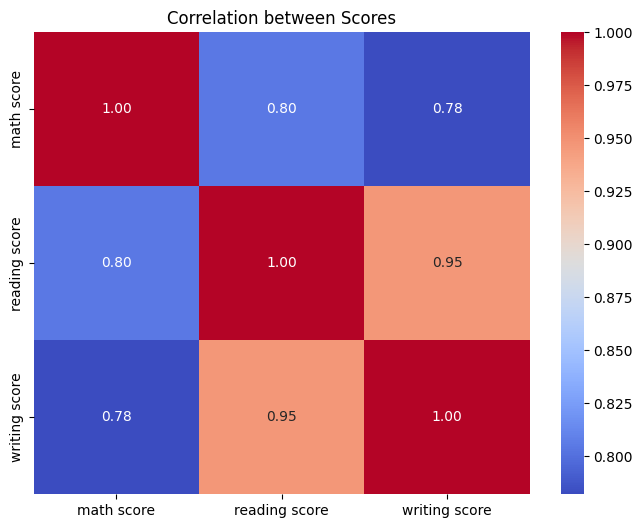

In [926]:
# create a correlation heatmap between scores
plt.figure(figsize=(8, 6))
sns.heatmap(exams_df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Scores')
plt.show()


In [927]:
# calcualte the correlation of the numerical columns
target = 'reading score'

numerical_data = exams_df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

correlation = correlation_matrix[target].abs().sort_values(ascending=False)
print(correlation)


reading score    1.000000
writing score    0.946702
math score       0.804398
Name: reading score, dtype: float64


In [928]:
# calculate the Python Predictive Power Score (PPS) for the target
# and display only those with a score above 0
pps_scores = []

for feature in exams_df.columns:
    if feature != target:
        score = pps.score(exams_df, feature, target)

        pps_scores.append({
            'x': feature,
            'y': target,
            'ppscore': score['ppscore'],
              'case': score['case'],
            'model': score.get('model', None),
            'model_score': score.get('model_score', None),
            'baseline_score': score.get('baseline_score', None),
            'comparison': score.get('comparison', None)
        })

pps_df = pd.DataFrame(pps_scores)
pps_df.loc[pps_df['ppscore'] != 0]

,x,y,ppscore,case,model,model_score,baseline_score,comparison
0,gender,reading score,0.022189,regression,DecisionTreeRegressor(),10.970155,11.219095,None
1,race/ethnicity,reading score,0.014421,regression,DecisionTreeRegressor(),11.057301,11.219095,None
3,lunch,reading score,0.031113,regression,DecisionTreeRegressor(),10.870033,11.219095,None
4,test preparation course,reading score,0.019424,regression,DecisionTreeRegressor(),11.001177,11.219095,None
5,math score,reading score,0.364654,regression,DecisionTreeRegressor(),7.128010,11.219095,None
6,writing score,reading score,0.664740,regression,DecisionTreeRegressor(),3.761310,11.219095,None


In [929]:
# select features and split the data into train/test data
features = ['writing score', 'math score', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course'] # features chosen by correlation
# features = ['writing score', 'math score', 'race/ethnicity', 'gender', 'lunch', 'test preparation course'] # features chosen by pps


X = exams_df[features]
y = exams_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae_scores = {}
rmse_scores = {}

In [930]:
# Linear Regression
linear_model = LinearRegression()
train_and_evaluate_model(linear_model, 'Linear Regression', features)

# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
train_and_evaluate_model(tree_model, 'Decision Tree', features)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
train_and_evaluate_model(rf_model, 'Random Forest', features)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [931]:
# print the range of the target
print(f"Range of {target}: {exams_df[target].min():.0f}-{exams_df[target].max():.0f}")

# print all MAE and RMSE scores with error percentages
for model_name in mae_scores:
    mae = mae_scores[model_name]
    mae_percentage_error = (mae / y_test.mean()) * 100
    print(f"{model_name}: MAE = {mae:.2f} (Error %: {mae_percentage_error:.2f}%), RMSE = {rmse_scores[model_name]:.2f} (Error %: {(rmse_scores[model_name] / y_test.mean()) * 100:.2f}%)")


Range of reading score: 32-100
Linear Regression: MAE = 3.56 (Error %: 5.02%), RMSE = 4.45 (Error %: 6.28%)
Decision Tree: MAE = 7.51 (Error %: 10.58%), RMSE = 10.73 (Error %: 15.12%)
Random Forest: MAE = 5.68 (Error %: 8.00%), RMSE = 7.71 (Error %: 10.86%)


# student_data



Secondary education of two Portuguese schools

In [932]:
# read student_data.csv into a DataFrame
data_df = pd.read_csv("/content/student_data.csv")
data_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [933]:
# print student_data.csv info
data_df.info()
print("Columns: ", data_df.columns)
print("Record Count: ", len(data_df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [934]:
# check if there are any null values and remove outliers
# print(data_df.isnull().sum())
columns_to_check = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

z_scores = stats.zscore(data_df[columns_to_check].select_dtypes(include=['float64', 'int64']), nan_policy='omit')
data_df = data_df[(abs(z_scores) < 3).all(axis=1)]

In [935]:
# visulaize the distribution of the categorical columns
categorical_cols = [
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
    'nursery', 'higher', 'internet', 'romantic'
]

# for col in categorical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.countplot(data_df[col])
#     plt.title(f'Distribution of {col}')
#     plt.show()


In [936]:
# visulaize the distribution of the numerical columns
numerical_cols = [
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
    'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(data_df[col])
#     plt.title(f'Distribution of {col}')
#     plt.show()

#     sns.boxplot(x=data_df[col])
#     plt.title(f'Box plot of {col}')
#     plt.show()


In [937]:
# add a column for the average of the 3 period's grades and remove G1, G2, and G3
grad_mean = (data_df.G1 + data_df.G2 + data_df.G3) / 3
data_df['G_Mean'] = grad_mean
data_df.drop(columns=['G1', 'G2', 'G3'], inplace=True)
data_df.head(4)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G_Mean
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,5.666667
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,5.333333
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,14.666667
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,8.666667


In [938]:
# # compare categorical columns versus the average grade
# for col in categorical_cols:
#     plt.figure(figsize=(8, 5))
#     sns.boxplot(x=col, y='G_Mean', data=data_df)
#     plt.title(f'Grade by {col}')
#     plt.xticks(rotation=45)
#     plt.show()


In [939]:
# # compare numerical columns versus the average grade
# for col in numerical_cols:
#     plt.figure(figsize=(6, 4))
#     sns.scatterplot(x=col, y='G_Mean', data=data_df)
#     plt.title(f'Grade vs {col}')
#     plt.show()


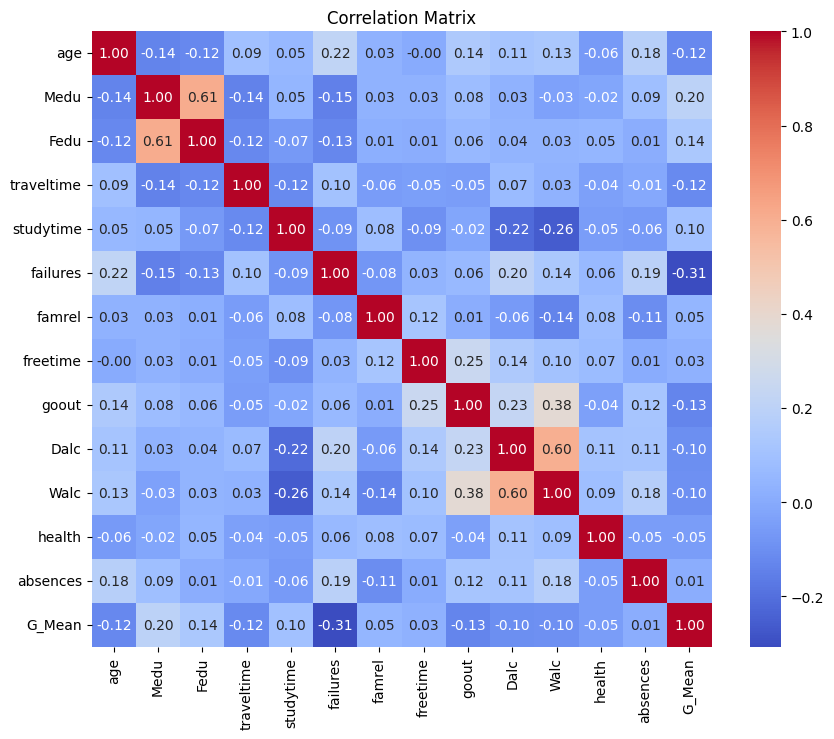

G_Mean        1.000000
failures      0.308562
Medu          0.200887
Fedu          0.136099
goout         0.134215
age           0.121526
traveltime    0.118606
Dalc          0.100303
Walc          0.096564
studytime     0.095869
health        0.052064
famrel        0.047856
freetime      0.027136
absences      0.010872
Name: G_Mean, dtype: float64


In [940]:
# create a correlation heatmap
numerical_data = data_df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


correlation_matrix = numerical_data.corr()
correlation = correlation_matrix['G_Mean'].abs().sort_values(ascending=False)
print(correlation)


In [941]:
# calculate the Python Predictive Power Score (PPS) for the average grade
# and display only those with a score above 0
target = 'G_Mean'
pps_scores = []

for feature in data_df.columns:
    if feature != target:
        score = pps.score(data_df, feature, target)

        pps_scores.append({
            'x': feature,
            'y': target,
            'ppscore': score['ppscore'],
              'case': score['case'],
            'model': score.get('model', None),
            'model_score': score.get('model_score', None),
            'baseline_score': score.get('baseline_score', None),
            'comparison': score.get('comparison', None)
        })

pps_df = pd.DataFrame(pps_scores)
pps_df.loc[pps_df['ppscore'] != 0]

,x,y,ppscore,case,model,model_score,baseline_score,comparison
1,sex,G_Mean,0.007915,regression,DecisionTreeRegressor(),2.931542,2.95493,None
3,address,G_Mean,0.002715,regression,DecisionTreeRegressor(),2.946907,2.95493,None
6,Medu,G_Mean,0.011306,regression,DecisionTreeRegressor(),2.921522,2.95493,None
8,Mjob,G_Mean,0.017526,regression,DecisionTreeRegressor(),2.903142,2.95493,None
14,failures,G_Mean,0.039847,regression,DecisionTreeRegressor(),2.837185,2.95493,None
15,schoolsup,G_Mean,0.023609,regression,DecisionTreeRegressor(),2.885165,2.95493,None
16,famsup,G_Mean,0.000047,regression,DecisionTreeRegressor(),2.954792,2.95493,None
20,higher,G_Mean,0.002386,regression,DecisionTreeRegressor(),2.947880,2.95493,None
21,internet,G_Mean,0.000185,regression,DecisionTreeRegressor(),2.954384,2.95493,None
24,freetime,G_Mean,0.013915,regression,DecisionTreeRegressor(),2.913812,2.95493,None


In [942]:
# select features and split into train/test data
# features = ['failures', 'Medu', 'Fedu', 'goout'] # features chosen by correlation
features = ['sex', 'address', 'Medu', 'Mjob', 'failures', 'schoolsup', 'famsup', 'higher', 'internet', 'freetime'] # features chosen by PPS

X = data_df[features]
y = data_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mae_scores = {}
rmse_scores = {}

In [943]:
# Linear Regression
linear_model = LinearRegression()
train_and_evaluate_model(linear_model, 'Linear Regression', features)

# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
train_and_evaluate_model(tree_model, 'Decision Tree', features)

# Random Forest
rf_model = RandomForestRegressor(random_state=42)
train_and_evaluate_model(rf_model, 'Random Forest', features)

In [944]:
# print the range of the grade average
print(f"Range of {target} score: {data_df[target].min():.2f} - {data_df[target].max():.2f}")


# print all MAE and RMSE scores with error percentages
for model_name in mae_scores:
    mae = mae_scores[model_name]
    mae_percentage_error = (mae / y_test.mean()) * 100
    print(f"{model_name}: MAE = {mae:.2f} (Error %: {mae_percentage_error:.2f}%), RMSE = {rmse_scores[model_name]:.2f} (Error %: {(rmse_scores[model_name] / y_test.mean()) * 100:.2f}%)")


Range of G_Mean score: 1.33 - 19.33
Linear Regression: MAE = 2.15 (Error %: 20.86%), RMSE = 2.71 (Error %: 26.32%)
Decision Tree: MAE = 3.53 (Error %: 34.27%), RMSE = 4.47 (Error %: 43.38%)
Random Forest: MAE = 2.56 (Error %: 24.80%), RMSE = 3.10 (Error %: 30.11%)
